# Run All

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from sklearn import datasets #Import scikit-learn dataset library
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
import os
from sklearn import svm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
# from tensorflow.keras import backend as K

In [3]:
tf.random.set_seed(42)

In [4]:
def norm_features(X):
    hmm2 = np.empty([983484, 66])
    count = 0
    for col in X:
        hmm = []
        min = X[col].min()
        max = X[col].max()
        for i in X[col]:
            xnew = ((i - min) / (max - min)) * 255
            hmm.append(xnew)
        hmm2[:,count] = np.array(hmm)
        #break
        count += 1
    return hmm2

In [5]:
# 66 x 66 x 3 each 198 sample will be an image
def conv_img(X):
    img = np.empty([4967,66,66,3])
    i = 0
    for j in range(4967):
        for c in range(3):
            for k in range(66):
                img[j,:,k,c] = X[i,:]
                i += 1
    return img

In [6]:
X = pd.read_csv('/content/gdrive/MyDrive/AI_for_CS/X_preprocessed.csv')

In [7]:
X = X.drop(columns = ['Unnamed: 0'])

In [8]:
y = pd.read_csv('/content/gdrive/MyDrive/AI_for_CS/y_preprocessed.csv')
y = y["Label"]
df = X.join(y)
df = df.sort_values(by=['Label']) #sort for images
X = df.drop(columns = ['Label'])

In [9]:
X.shape

(983484, 66)

In [10]:
norm = norm_features(X)

In [11]:
img = conv_img(norm)
img.shape

(4967, 66, 66, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


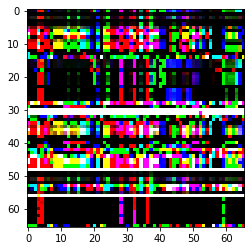

In [12]:
imageA = img[10]
plt.imshow(imageA) #benign

In [13]:
y = 150 * [0] + 486 * [1] + 494 * [2] + 488 * [3] + 503 * [4] + 480 * [5] + 503 * [6] + 499 * [7] + 494 * [8] + 433 * [9] + 437 * [10] 
print(len(y))

4967


In [14]:
import cv2
images = []
for image in img:
  images.append(cv2.resize(image, (71,71), interpolation = cv2.INTER_AREA)) #to be applicable with Xception
images = np.array(images)
images.shape

(4967, 71, 71, 3)

In [15]:
indices = list(range(len(images)))
nClasses = 11
# Use Keras' handy utils
split = train_test_split(images, y, indices, test_size=0.2, random_state=42)
(trainX, validateX, trainY, validateY, indices_train, indices_test) = split
y_train_k = tensorflow.keras.utils.to_categorical(trainY, num_classes=nClasses)
y_val_k = tensorflow.keras.utils.to_categorical(validateY, num_classes=nClasses)

# Don't run just for illustration xD

In [16]:
from tensorflow.keras.applications import Xception
XceptionModel = tf.keras.applications.Xception(
                include_top=False,
                weights='imagenet',
                input_shape=(71, 71, 3),
                classes=11,
                classifier_activation="softmax")

In [17]:
print(XceptionModel.summary())

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 35, 35, 32)   0           ['block1_conv1_bn[0][0]'] 

In [18]:
from keras.layers import Dropout, BatchNormalization
for layer in XceptionModel.layers:
    layer.trainable = True

# last layers output
x = XceptionModel.layers[-1].output

x = Flatten(name='flatten')(x)
x = Dense(1024, activation='relu', name='fc1')(x)
x = BatchNormalization()(x)
x = Dropout(.2)(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dropout(.2)(x)
x = Dense(1024, activation='relu', name='fc3')(x)

x = Dense(11, activation='softmax', name='predictions')(x) # lazm output 11 3shan l classes
from tensorflow.keras.models import Model
Xception_transfer = Model(inputs=XceptionModel.input, outputs=x)

In [19]:
#print(Xception_transfer.summary())

In [20]:
batchSize = 64
nEpochs = 12
    
rmsprop = tf.keras.optimizers.Adam(learning_rate=0.0001)
Xception_transfer.compile(loss='categorical_crossentropy', 
                           optimizer=rmsprop, 
                           metrics=['accuracy'])


history = Xception_transfer.fit(trainX, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(validateX, y_val_k))  # dol mn l split l fo2


Epoch 1/12
63/63 [==============================] - 16s 129ms/step - loss: 0.8189 - accuracy: 0.7078 - val_loss: 2.2258 - val_accuracy: 0.1519
Epoch 2/12
63/63 [==============================] - 7s 106ms/step - loss: 0.2580 - accuracy: 0.8910 - val_loss: 2.2724 - val_accuracy: 0.1590
Epoch 3/12
63/63 [==============================] - 7s 106ms/step - loss: 0.2121 - accuracy: 0.9044 - val_loss: 1.6275 - val_accuracy: 0.4225
Epoch 4/12
63/63 [==============================] - 7s 106ms/step - loss: 0.1876 - accuracy: 0.9184 - val_loss: 0.5665 - val_accuracy: 0.7998
Epoch 5/12
63/63 [==============================] - 7s 106ms/step - loss: 0.1690 - accuracy: 0.9330 - val_loss: 0.2351 - val_accuracy: 0.8883
Epoch 6/12
63/63 [==============================] - 7s 107ms/step - loss: 0.1246 - accuracy: 0.9519 - val_loss: 0.2468 - val_accuracy: 0.9064
Epoch 7/12
63/63 [==============================] - 7s 107ms/step - loss: 0.1440 - accuracy: 0.9441 - val_loss: 0.3340 - val_accuracy: 0.8954
Epoch

In [38]:
y_prob = Xception_transfer.predict(validateX)
y_probtrain = Xception_transfer.predict(trainX)

In [39]:
y_pred = y_prob.argmax(axis=-1)

In [40]:
print("Report : \n",classification_report(validateY, y_pred))

Report : 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.99      0.98      0.99       106
           2       0.99      1.00      1.00       105
           3       1.00      0.99      0.99        98
           4       1.00      1.00      1.00        99
           5       1.00      0.99      0.99        96
           6       0.99      1.00      0.99        95
           7       0.55      0.80      0.65        79
           8       0.76      0.51      0.61       102
           9       0.92      0.88      0.90        88
          10       0.88      0.92      0.90        91

    accuracy                           0.91       994
   macro avg       0.92      0.91      0.91       994
weighted avg       0.92      0.91      0.91       994



In [42]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

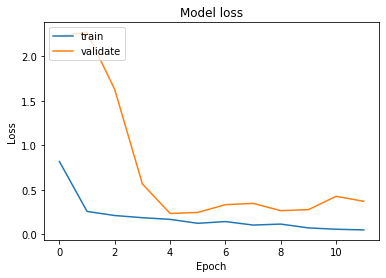

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [26]:
Xception_prob = np.append(y_probtrain, y_prob, axis=0)

In [27]:
Xception_prob.shape

(4967, 11)

In [28]:
full_index =  indices_train + indices_test

In [29]:
len(full_index)

4967

In [30]:
sorted_Prob = [x for _,x in sorted(zip(full_index, Xception_prob))]

In [31]:
sorted_Prob = np.array(sorted_Prob)

In [32]:
sorted_Prob.shape

(4967, 11)

In [33]:
from numpy import savetxt
savetxt('Probabilities_Xception_final.csv', sorted_Prob, delimiter=',')

In [34]:
!cp Probabilities_Xception_final.csv "/content/gdrive/MyDrive/AI_for_CS"

In [35]:
from tensorflow.keras.applications import Xception
XceptionModel_Reg = tf.keras.applications.Xception(
                include_top=False,
                weights=None,
                input_shape=(71, 71, 3),
                classes=1,
                classifier_activation=None)

In [36]:
from keras.layers import Dropout, BatchNormalization
for layer in XceptionModel_Reg.layers:
    layer.trainable = True

# last layers output
x = XceptionModel_Reg.layers[10].output
# Flatten as before

# Classification block
x = Flatten(name='flatten')(x)
x = BatchNormalization()(x)
x = Dense(1, activation='linear', name='predictions')(x) # lazm output 11 3shan l classes
from tensorflow.keras.models import Model
Xception_transfer_Reg = Model(inputs=XceptionModel_Reg.input, outputs=x)

In [37]:
batchSize = 128
nEpochs = 32
mse = tf.keras.losses.MeanSquaredError()

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
Xception_transfer_Reg.compile(loss=mse, 
                           optimizer=adam)


history = Xception_transfer_Reg.fit(trainX, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(validateX, y_val_k))  # dol mn l split l fo2

Epoch 1/32
32/32 [==============================] - 4s 76ms/step - loss: 1.5478 - val_loss: 0.0830
Epoch 2/32
32/32 [==============================] - 2s 66ms/step - loss: 0.3657 - val_loss: 0.0896
Epoch 3/32
32/32 [==============================] - 2s 67ms/step - loss: 0.2360 - val_loss: 0.0925
Epoch 4/32
32/32 [==============================] - 2s 66ms/step - loss: 0.1924 - val_loss: 0.1016
Epoch 5/32
32/32 [==============================] - 2s 67ms/step - loss: 0.1614 - val_loss: 0.1131
Epoch 6/32
32/32 [==============================] - 2s 67ms/step - loss: 0.1637 - val_loss: 0.1375
Epoch 7/32
32/32 [==============================] - 2s 66ms/step - loss: 0.1578 - val_loss: 0.1281
Epoch 8/32
32/32 [==============================] - 2s 66ms/step - loss: 0.1752 - val_loss: 0.2209
Epoch 9/32
32/32 [==============================] - 2s 66ms/step - loss: 0.1827 - val_loss: 0.1223
Epoch 10/32
32/32 [==============================] - 2s 67ms/step - loss: 0.2247 - val_loss: 0.1812
Epoch 11/